# Gibbs Sampling
#### Sean Wade

In [1]:
import numpy as np
from math import sqrt
from scipy.stats import norm, gaussian_kde, invgamma
import csv

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter_3.css').read())

## Problem 1

In [2]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """
    Assuming a likelihood and priors
        y_i ~ N(mu, sigma2),
        mu ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),
    sample from the posterior distribution
        P(mu, sigma2 | y, nu, tau2, alpha, beta)
    using a gibbs sampler.
    
    Parameters
    ----------
    y : ndarray of shape (N,)
        The data
    nu : float
        The prior mean parameter for mu
    tau2 : float > 0
        The prior variance parameter for mu
    alpha : float > 0
        The prior alpha parameter for sigma2
    beta : float > 0
        The prior beta parameter for sigma2
    n_samples : int
        The number of samples to draw
    
    Returns
    -------
    samples : ndarray of shape (n_samples,2)
        1st col = mu samples, 2nd col = sigma2 samples
    """
    N = len(y)
    
    samples = np.zeros((n_samples,2))
    # Set initial variables
    samples[0,0] = norm.rvs(nu, scale=sqrt(tau2))
    samples[0,1] = invgamma.rvs(alpha, scale=beta)
        
    for k in range(1, n_samples):
        mu = samples[k-1, 0]
        sigma2 = samples[k-1, 1]
        
        sigma2_s = 1/(1/tau2 + N/sigma2)
        mu_s = sigma2_s * (nu/tau2 + 1/sigma2 * np.sum(y))
        alpha_s = alpha + N/2
        beta_s = beta + 1/2 * np.sum((y - mu)**2)
            
        samples[k,0] = norm.rvs(mu_s, scale=sqrt(sigma2_s))
        samples[k,1] = invgamma.rvs(alpha_s, scale=beta_s)

    return samples

In [21]:
data = np.loadtxt('data/examscores.csv', delimiter=',')

In [22]:
samples = gibbs(data, 80, 16, 3, 50, 1000)

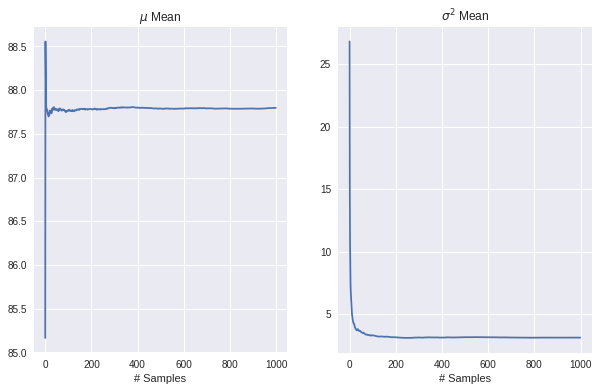

In [20]:
mu_sample_mean = [np.mean(samples[:i,0]) for i in xrange(1, len(samples))]
sigma_sample_mean = [np.mean(samples[:i,1]) for i in xrange(1, len(samples))]


plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(mu_sample_mean)
plt.xlabel('# Samples')
plt.title(r'$\mu$ Mean')

plt.subplot(122)
plt.plot(sigma_sample_mean)
plt.xlabel('# Samples')
plt.title(r'$\sigma^2$ Mean')
plt.show()

These converge at about 100 samples.

## Problem 2

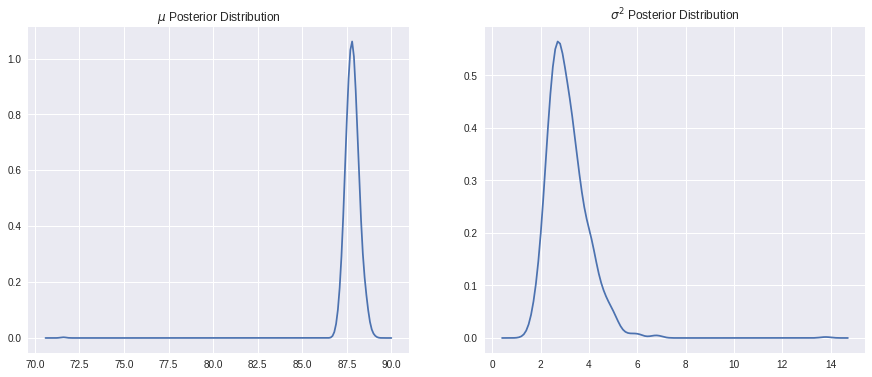

In [26]:
mu_kernel = gaussian_kde(samples[:,0])

x_min = min(samples[:,0]) - 1
x_max = max(samples[:,0]) + 1
x = np.arange(x_min, x_max, step=0.1)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(x, mu_kernel(x))
plt.title(r'$\mu$ Posterior Distribution')

sigma2_kernel = gaussian_kde(samples[:,1])
x_min = min(samples[:,1]) - 1
x_max = max(samples[:,1]) + 1
x = np.arange(x_min, x_max, step=0.1)

plt.subplot(122)
plt.plot(x,sigma2_kernel(x))
plt.title(r'$\sigma^2$ Posterior Distribution')
plt.show()

## Problem 3

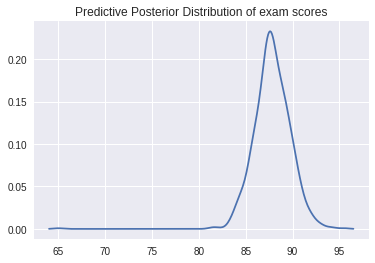

In [27]:
sample_scores = [norm.rvs(s[0], scale=sqrt(s[1])) for s in samples]
score_kernel = gaussian_kde(sample_scores)

x_min = min(sample_scores) - 1
x_max = max(sample_scores) + 1
x = np.arange(x_min, x_max, step=0.1)

plt.plot(x,score_kernel(x))
plt.title(r'Predictive Posterior Distribution of exam scores')
plt.show()